# Geostrophic adjustment in the hydrostatic Boussinesq equations

This example simulates a one-dimensional geostrophic adjustement problem
using the `ClimateMachine.Ocean` subcomponent to solve the hydrostatic
Boussinesq equations.

First we `ClimateMachine.init()`.

In [1]:
using ClimateMachine

ClimateMachine.init()

# Domain setup

We formulate our problem in a Cartesian domain 100 km in ``x, y`` and 400 m
deep, and discretized on a grid with 100 fourth-order elements in ``x``, and 1
fourth-order element in ``y, z``,

In [2]:
# Domain
Lx = 1e6   # m
Ly = 1e6   # m
Lz = 400.0 # m

# Numerical parameters
Np = 4           # Polynomial order
Ne = (25, 1, 1) # Number of elements in (x, y, z)
nothing # hide

# Physical parameters

We use a Coriolis parameter appropriate for mid-latitudes,

In [3]:
f = 1e-4 # s⁻¹, Coriolis parameter
nothing # hide

and Earth's gravitational acceleration,

In [4]:
using CLIMAParameters: AbstractEarthParameterSet, Planet
gravitational_acceleration = Planet.grav
struct EarthParameters <: AbstractEarthParameterSet end

g = gravitational_acceleration(EarthParameters()) # m s⁻²

9.81

# An unbalanced initial state

We use a Gaussian, partially-balanced initial condition with parameters

In [5]:
U = 0.1            # geostrophic velocity (m s⁻¹)
L = Lx / 40        # Gaussian width (m)
a = f * U * L / g  # amplitude of the geostrophic surface displacement (m)
x₀ = Lx / 4        # Gaussian origin (m, recall that x ∈ [0, Lx])

250000.0

and functional form

In [6]:
Ψ(x, L) = exp(-x^2 / 2 * L^2) # a Gaussian

# Geostrophic ``y``-velocity
vᵍ(x, y, z) = -U * (x - x₀) / L * Ψ(x - x₀, L)

# Geostrophic surface displacement
ηᵍ(x, y, z) = a * Ψ(x - x₀, L)

ηᵍ (generic function with 1 method)

We double the initial surface displacement so that the surface is half-balanced,
half unbalanced,

In [7]:
ηⁱ(x, y, z) = 2 * ηᵍ(x, y, z)

ηⁱ (generic function with 1 method)

In summary,

In [8]:
using ClimateMachine.Ocean.OceanProblems: InitialConditions

initial_conditions = InitialConditions(v = vᵍ, η = ηⁱ)

@info """ Parameters for the Geostrophic adjustment problem are...

    Coriolis parameter:                            $f s⁻¹
    Gravitational acceleration:                    $g m s⁻²
    Geostrophic velocity:                          $U m s⁻¹
    Width of the initial geostrophic perturbation: $L m
    Amplitude of the initial surface perturbation: $a m
    Rossby number (U / f L):                       $(U / (f * L))

"""

┌ Info:  Parameters for the Geostrophic adjustment problem are...
│ 
│     Coriolis parameter:                            0.0001 s⁻¹
│     Gravitational acceleration:                    9.81 m s⁻²
│     Geostrophic velocity:                          0.1 m s⁻¹
│     Width of the initial geostrophic perturbation: 25000.0 m
│     Amplitude of the initial surface perturbation: 0.0254841997961264 m
│     Rossby number (U / f L):                       0.04
│ 
└ @ Main.##366 string:5


# Boundary conditions, Driver configuration, and Solver configuration

Next, we configure the `HydrostaticBoussinesqModel` and build the `DriverConfiguration`.
We configure our model in a domain which is bounded in the ``x`` direction.
Both the boundary conditions in ``x`` and in ``z`` require boundary conditions,
which we define:

In [9]:
using ClimateMachine.Ocean:
    Impenetrable, Penetrable, FreeSlip, Insulating, OceanBC

solid_surface_boundary_conditions = OceanBC(
    Impenetrable(FreeSlip()), # Velocity boundary conditions
    Insulating(),             # Temperature boundary conditions
)

free_surface_boundary_conditions = OceanBC(
    Penetrable(FreeSlip()),   # Velocity boundary conditions
    Insulating(),             # Temperature boundary conditions
)

boundary_conditions =
    (solid_surface_boundary_conditions, free_surface_boundary_conditions)

(ClimateMachine.Ocean.OceanBC{ClimateMachine.Ocean.Impenetrable{ClimateMachine.Ocean.FreeSlip},ClimateMachine.Ocean.Insulating}(ClimateMachine.Ocean.Impenetrable{ClimateMachine.Ocean.FreeSlip}(ClimateMachine.Ocean.FreeSlip()), ClimateMachine.Ocean.Insulating()), ClimateMachine.Ocean.OceanBC{ClimateMachine.Ocean.Penetrable{ClimateMachine.Ocean.FreeSlip},ClimateMachine.Ocean.Insulating}(ClimateMachine.Ocean.Penetrable{ClimateMachine.Ocean.FreeSlip}(ClimateMachine.Ocean.FreeSlip()), ClimateMachine.Ocean.Insulating()))

We refer to these boundary conditions by their indices in the `boundary_conditions` tuple
when speicfying the boundary conditions for the `state`; in other words, "1" corresponds to
`solid_surface_boundary_conditions`, while `2` corresponds to `free_surface_boundary_conditions`,

In [10]:
state_boundary_conditions = (
    (1, 1), # (west, east) boundary conditions
    (0, 0), # (south, north) boundary conditions
    (1, 2), # (bottom, top) boundary conditions
)

((1, 1), (0, 0), (1, 2))

We're now ready to build the `InitialValueProblem`,

In [11]:
using ClimateMachine.Ocean.OceanProblems: InitialValueProblem

problem = InitialValueProblem{Float64}(
    dimensions = (Lx, Ly, Lz),
    initial_conditions = initial_conditions,
    boundary_conditions = boundary_conditions,
)

ClimateMachine.Ocean.OceanProblems.InitialValueProblem{Float64,ClimateMachine.Ocean.OceanProblems.InitialConditions{typeof(ClimateMachine.Ocean.OceanProblems.resting),typeof(Main.##366.vᵍ),typeof(ClimateMachine.Ocean.OceanProblems.resting),typeof(Main.##366.ηⁱ)},Tuple{ClimateMachine.Ocean.OceanBC{ClimateMachine.Ocean.Impenetrable{ClimateMachine.Ocean.FreeSlip},ClimateMachine.Ocean.Insulating},ClimateMachine.Ocean.OceanBC{ClimateMachine.Ocean.Penetrable{ClimateMachine.Ocean.FreeSlip},ClimateMachine.Ocean.Insulating}}}(1.0e6, 1.0e6, 400.0, ClimateMachine.Ocean.OceanProblems.InitialConditions{typeof(ClimateMachine.Ocean.OceanProblems.resting),typeof(Main.##366.vᵍ),typeof(ClimateMachine.Ocean.OceanProblems.resting),typeof(Main.##366.ηⁱ)}(ClimateMachine.Ocean.OceanProblems.resting, Main.##366.vᵍ, ClimateMachine.Ocean.OceanProblems.resting, Main.##366.ηⁱ), (ClimateMachine.Ocean.OceanBC{ClimateMachine.Ocean.Impenetrable{ClimateMachine.Ocean.FreeSlip},ClimateMachine.Ocean.Insulating}(ClimateMa

and the `HydrostaticBoussinesqModel` representing the
hydrostatic Boussinesq equations,

In [12]:
using ClimateMachine.Ocean.HydrostaticBoussinesq: HydrostaticBoussinesqModel

equations = HydrostaticBoussinesqModel{Float64}(
    EarthParameters(),
    problem,
    νʰ = 0.0,          # Horizontal viscosity (m² s⁻¹)
    κʰ = 0.0,          # Horizontal diffusivity (m² s⁻¹)
    fₒ = f,             # Coriolis parameter (s⁻¹)
)

ClimateMachine.Ocean.HydrostaticBoussinesq.HydrostaticBoussinesqModel{ClimateMachine.Ocean.Uncoupled,Main.##366.EarthParameters,ClimateMachine.Ocean.OceanProblems.InitialValueProblem{Float64,ClimateMachine.Ocean.OceanProblems.InitialConditions{typeof(ClimateMachine.Ocean.OceanProblems.resting),typeof(Main.##366.vᵍ),typeof(ClimateMachine.Ocean.OceanProblems.resting),typeof(Main.##366.ηⁱ)},Tuple{ClimateMachine.Ocean.OceanBC{ClimateMachine.Ocean.Impenetrable{ClimateMachine.Ocean.FreeSlip},ClimateMachine.Ocean.Insulating},ClimateMachine.Ocean.OceanBC{ClimateMachine.Ocean.Penetrable{ClimateMachine.Ocean.FreeSlip},ClimateMachine.Ocean.Insulating}}},Nothing,ClimateMachine.Ocean.NonLinearAdvectionTerm,Float64}(Main.##366.EarthParameters(), ClimateMachine.Ocean.OceanProblems.InitialValueProblem{Float64,ClimateMachine.Ocean.OceanProblems.InitialConditions{typeof(ClimateMachine.Ocean.OceanProblems.resting),typeof(Main.##366.vᵍ),typeof(ClimateMachine.Ocean.OceanProblems.resting),typeof(Main.##366.

and the `DriverConfiguration`,

In [13]:
driver_configuration = ClimateMachine.OceanBoxGCMConfiguration(
    "Geostrophic adjustment tutorial",    # The name of the experiment
    Np,                                   # The polynomial order
    Ne,                                   # The number of elements
    EarthParameters(),                    # The CLIMAParameters.AbstractParameterSet to use
    equations;                            # The equations to solve, represented by a `BalanceLaw`
    periodicity = (false, true, false),   # Topology of the domain
    boundary = state_boundary_conditions,
)
nothing # hide

!!! info "Horizontallly-periodic boundary conditions"
    To set horizontally-periodic boundary conditions with
    `(solid_surface_boundary_conditions, free_surface_boundary_conditions)`
    in the vertical direction use `periodicity = (true, true, false)` and
    and `boundary = ((0, 0), (0, 0), (1, 2))` in the constructor for
    `OceanBoxGCMConfiguration`.

# Filters

The `HydrostaticBoussinesqModel` currently assumes that both `vert_filter`
and `exp_filter` are supplied to `modeldata` in `SolverConfiguration`.
We define these required objects,

In [14]:
using ClimateMachine.Mesh.Filters
using ClimateMachine.Mesh.Grids: polynomialorder

grid = driver_configuration.grid

filters = (
    vert_filter = CutoffFilter(grid, polynomialorder(grid) - 1),
    exp_filter = ExponentialFilter(grid, 1, 8),
)

(vert_filter = ClimateMachine.Mesh.Filters.CutoffFilter([0.4499999999999999 1.001300497744848 … -0.06796716441151489 0.14999999999999994; 0.18391233632048226 0.6500000000000001 … -0.05000000000000007 -0.012483764891910864; … ; -0.012483764891910987 -0.04999999999999981 … 0.6499999999999999 0.18391233632048234; 0.14999999999999988 -0.06796716441151449 … 1.0013004977448479 0.45000000000000023]), exp_filter = ClimateMachine.Mesh.Filters.ExponentialFilter([0.5343914961549586 0.869232923065416 … 0.06196985932412315 0.06286922406016343; 0.15965502668548448 0.686602590381471 … -0.0869069548020128 0.01138221905953283; … ; 0.011382219059532782 -0.08690695480201271 … 0.6866025903814709 0.15965502668548454; 0.06286922406016338 0.061969859324123557 … 0.8692329230654159 0.5343914961549588]))

# Configuring the solver

We configure our solver with the `LSRK144NiegemannDiehlBusch` time-stepping method.

In [15]:
using ClimateMachine.ODESolvers

minute = 60.0
hours = 60minute

solver_configuration = ClimateMachine.SolverConfiguration(
    0.0,                    # start time (s)
    4hours,                 # stop time (s)
    driver_configuration,
    init_on_cpu = true,
    ode_dt = 1minute,       # time step size (s)
    ode_solver_type = ClimateMachine.ExplicitSolverType(
        solver_method = LSRK144NiegemannDiehlBusch,
    ),
    modeldata = filters,
)

┌ Info: Initializing Geostrophic adjustment tutorial
└ @ ClimateMachine /home/runner/work/ClimateMachine.jl/ClimateMachine.jl/src/Driver/solver_configs.jl:161


ClimateMachine.SolverConfiguration{Float64}("Geostrophic adjustment tutorial", MPI.Comm(1140850688), Main.##366.EarthParameters(), ClimateMachine.DGMethods.DGModel{ClimateMachine.Ocean.HydrostaticBoussinesq.HydrostaticBoussinesqModel{ClimateMachine.Ocean.Uncoupled,Main.##366.EarthParameters,ClimateMachine.Ocean.OceanProblems.InitialValueProblem{Float64,ClimateMachine.Ocean.OceanProblems.InitialConditions{typeof(ClimateMachine.Ocean.OceanProblems.resting),typeof(Main.##366.vᵍ),typeof(ClimateMachine.Ocean.OceanProblems.resting),typeof(Main.##366.ηⁱ)},Tuple{ClimateMachine.Ocean.OceanBC{ClimateMachine.Ocean.Impenetrable{ClimateMachine.Ocean.FreeSlip},ClimateMachine.Ocean.Insulating},ClimateMachine.Ocean.OceanBC{ClimateMachine.Ocean.Penetrable{ClimateMachine.Ocean.FreeSlip},ClimateMachine.Ocean.Insulating}}},Nothing,ClimateMachine.Ocean.NonLinearAdvectionTerm,Float64},ClimateMachine.Mesh.Grids.DiscontinuousSpectralElementGrid{Float64,3,4,125,Array,Array{Float64,1},Array{Float64,2},Array{Flo

and use a simple callback to log the progress of our simulation,

In [16]:
using ClimateMachine.GenericCallbacks: EveryXSimulationSteps

print_every = 10 # iterations
solver = solver_configuration.solver

tiny_progress_printer = EveryXSimulationSteps(print_every) do
    @info "Steps: $(solver.steps), time: $(solver.t), time step: $(solver.dt)"
end

ClimateMachine.GenericCallbacks.EveryXSimulationSteps(Main.##366.var"#1#2"(), 10, 0)

# Animating the solution

To animate the `ClimateMachine.Ocean` solution, we'll create a callback
that draws a plot and stores it in an array. When the simulation is finished,
we'll string together the plotted frames into an animation.

In [17]:
using Printf
using Plots

using ClimateMachine.Ocean.Fields: assemble
using ClimateMachine.Ocean.CartesianDomains: CartesianDomain, CartesianField

# CartesianDomain and CartesianField objects to help with plotting
domain = CartesianDomain(solver_configuration.dg.grid, Ne)

u = CartesianField(domain, solver_configuration.Q, 1)
v = CartesianField(domain, solver_configuration.Q, 2)
η = CartesianField(domain, solver_configuration.Q, 3)

# Container to hold the plotted frames
movie_plots = []

plot_every = 10 # iterations

plot_maker = EveryXSimulationSteps(plot_every) do
    u_assembly = assemble(u)
    v_assembly = assemble(v)
    η_assembly = assemble(η)

    umax = 0.5 * max(maximum(abs, u), maximum(abs, v))
    ulim = (-umax, umax)

    u_plot = plot(
        u_assembly.x,
        [u_assembly.data[:, 1, 1] v_assembly.data[:, 1, 1]],
        xlim = domain.x,
        ylim = (-0.7U, 0.7U),
        label = ["u" "v"],
        linewidth = 2,
        xlabel = "x (m)",
        ylabel = "Velocities (m s⁻¹)",
    )

    η_plot = plot(
        η_assembly.x,
        η_assembly.data[:, 1, 1],
        xlim = domain.x,
        ylim = (-0.01a, 1.2a),
        linewidth = 2,
        label = nothing,
        xlabel = "x (m)",
        ylabel = "η (m)",
    )

    push!(
        movie_plots,
        (u = u_plot, η = η_plot, time = solver_configuration.solver.t),
    )

    return nothing
end

ClimateMachine.GenericCallbacks.EveryXSimulationSteps(Main.##366.var"#3#4"(), 10, 0)

# Running the simulation and animating the results

Finally, we run the simulation,

In [18]:
result = ClimateMachine.invoke!(
    solver_configuration;
    user_callbacks = [tiny_progress_printer, plot_maker],
)

┌ Info: Starting Geostrophic adjustment tutorial
│     dt              = 6.00000e+01
│     timeend         = 14400.00
│     number of steps = 240
│     norm(Q)         = 0.0000000000000000e+00
└ @ ClimateMachine /home/runner/work/ClimateMachine.jl/ClimateMachine.jl/src/Driver/Driver.jl:668
┌ Info: Steps: 10, time: 600.0, time step: 60.0
└ @ Main.##366 string:7
┌ Info: Steps: 20, time: 1200.0, time step: 60.0
└ @ Main.##366 string:7
┌ Info: Steps: 30, time: 1800.0, time step: 60.0
└ @ Main.##366 string:7
┌ Info: Steps: 40, time: 2400.0, time step: 60.0
└ @ Main.##366 string:7
┌ Info: Steps: 50, time: 3000.0, time step: 60.0
└ @ Main.##366 string:7
┌ Info: Steps: 60, time: 3600.0, time step: 60.0
└ @ Main.##366 string:7
┌ Info: Update
│     simtime =  3840.00 / 14400.00
│     runtime = 00:01:00
│     norm(Q) = 0.0000000000000000e+00
└ @ ClimateMachine.Callbacks /home/runner/work/ClimateMachine.jl/ClimateMachine.jl/src/Driver/Callbacks/Callbacks.jl:61
┌ Info: Steps: 70, time: 4200.0, time

NaN

and animate the results,

┌ Info: Saved animation to 
│   fn = /home/runner/work/ClimateMachine.jl/ClimateMachine.jl/docs/src/generated/Ocean/geostrophic_adjustment.gif
└ @ Plots /home/runner/.julia/packages/Plots/M1wcx/src/animation.jl:104


Plots.AnimatedGif("/home/runner/work/ClimateMachine.jl/ClimateMachine.jl/docs/src/generated/Ocean/geostrophic_adjustment.gif")
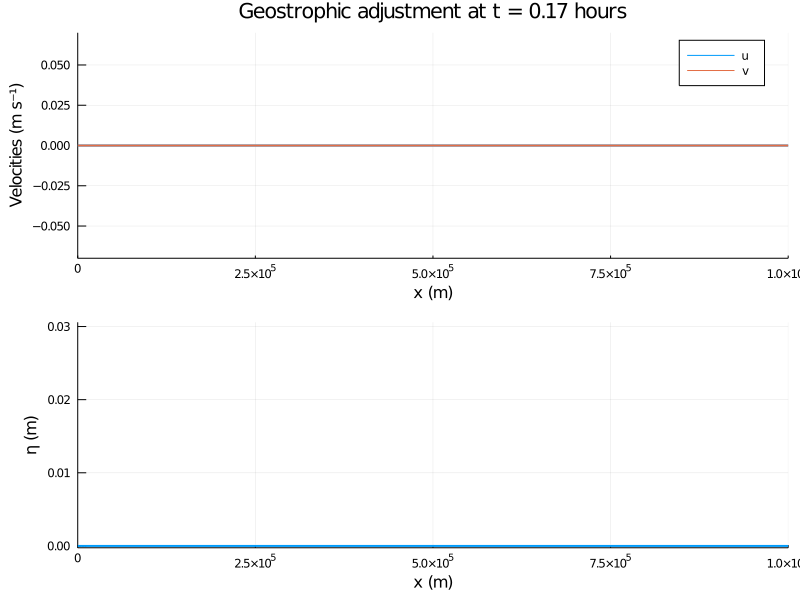

In [19]:
animation = @animate for p in movie_plots
    title = @sprintf("Geostrophic adjustment at t = %.2f hours", p.time / hours)
    frame = plot(
        p.u,
        p.η,
        layout = (2, 1),
        size = (800, 600),
        title = [title ""],
    )
end

gif(animation, "geostrophic_adjustment.gif", fps = 8) # hide

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*